In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

print('modules loaded')


modules loaded


In [2]:
data_dir = r"D:\CapstoneB\MKN maam\image7500f"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
labels = df['labels']
print(df)


                                              filepaths        labels
0     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
1     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
2     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
3     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
4     D:\CapstoneB\MKN maam\image7500f\image7500f\No...        Normal
...                                                 ...           ...
6995  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6996  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6997  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6998  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis
6999  D:\CapstoneB\MKN maam\image7500f\image7500f\Tu...  Tuberculosis

[7000 rows x 2 columns]


In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 10
k = 5  
NUM_CLASSES = 2


In [4]:
def get_callbacks(model_name):
    callbacks = []
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.keras', verbose=1, monitor='val_accuracy', mode='max')
    callbacks.append(checkpoint)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)
    return callbacks

def build_model():
    base_model = tf.keras.applications.DenseNet121(input_shape=img_shape, include_top=False, weights='imagenet')
    base_model.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adamax(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
  

In [5]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
fold_no = 1
accuracies = []

In [6]:
# Create lists to store history data for each fold
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Create a list to store confusion matrices
confusion_matrices = []

for train_index, test_index in skf.split(df['filepaths'], df['labels']):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    tr_gen = ImageDataGenerator()
    ts_gen = ImageDataGenerator()

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           color_mode='rgb', shuffle=True, batch_size=batch_size)

    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode='rgb', shuffle=False, batch_size=batch_size)

    g_dict = train_gen.class_indices
    classes = list(g_dict.keys())
    class_count = len(classes)

    model = build_model()
    callbacks = get_callbacks(f'DenseNet121_fold_{fold_no}')

    history = model.fit(train_gen,
                        epochs=epochs,
                        validation_data=test_gen,
                        callbacks=callbacks)

    # Store history data
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    ts_length = len(test_df)
    test_batch_size = min(32, ts_length)
    test_steps = ts_length // test_batch_size

    test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)
    print(f"Fold {fold_no} - Test Loss: ", test_score[0])
    print(f"Fold {fold_no} - Test Accuracy: ", test_score[1])

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    print(f"Classification Report for Fold {fold_no}")
    print(classification_report(test_gen.classes, y_pred, target_names=classes))

    # Store confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)
    confusion_matrices.append(cm)

    accuracies.append(test_score[1])
    fold_no += 1

Found 5600 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9649 - loss: 0.0832
Epoch 1: saving model to model.DenseNet121_fold_1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 946s 5s/step - accuracy: 0.9650 - loss: 0.0830 - val_accuracy: 1.0000 - val_loss: 1.5116e-04 - learning_rate: 0.0010
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9995 - loss: 0.0017
Epoch 2: saving model to model.DenseNet121_fold_1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 928s 5s/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 6.6935e-05 - learning_rate: 0.0010
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9996 - loss: 0.0011
Epoch 3: saving model to model.DenseNet121_fold_1.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 919s 5s/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.8879 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 4/10
175/175 ━━

In [7]:
print(f"Average accuracy over {k} folds: {np.mean(accuracies)}")

Average accuracy over 5 folds: 0.9998546481132508


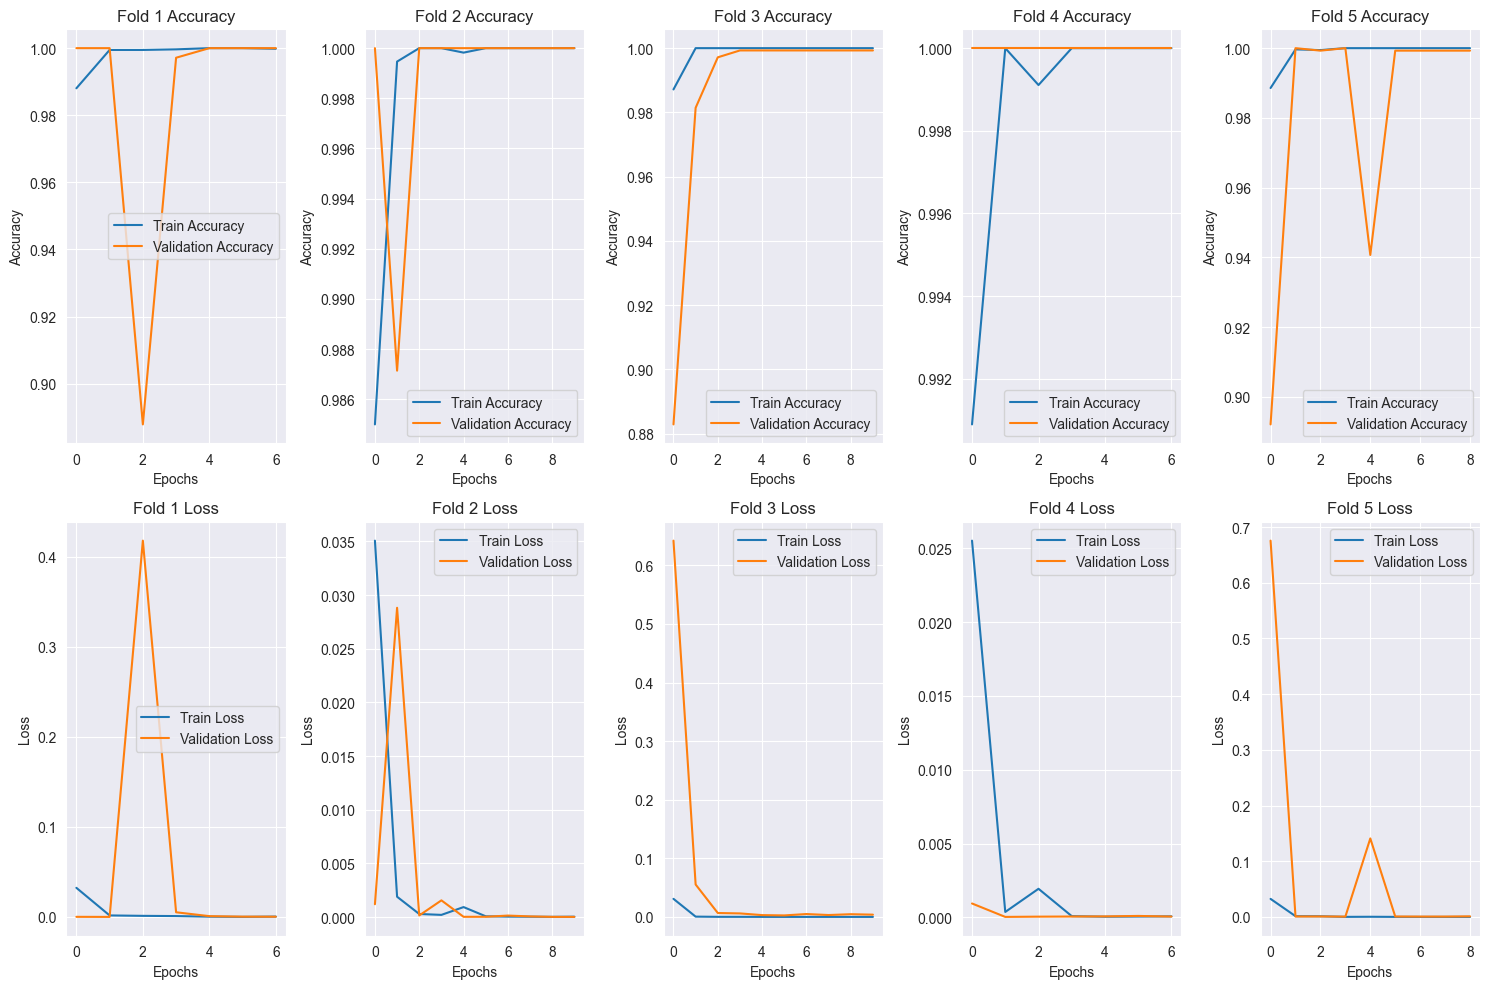

In [8]:
fig, axs = plt.subplots(2, k, figsize=(15, 10))

for i in range(k):
    # Accuracy plot
    axs[0, i].plot(train_accuracies[i], label='Train Accuracy')
    axs[0, i].plot(val_accuracies[i], label='Validation Accuracy')
    axs[0, i].set_title(f'Fold {i+1} Accuracy')
    axs[0, i].set_xlabel('Epochs')
    axs[0, i].set_ylabel('Accuracy')
    axs[0, i].legend()

    # Loss plot
    axs[1, i].plot(train_losses[i], label='Train Loss')
    axs[1, i].plot(val_losses[i], label='Validation Loss')
    axs[1, i].set_title(f'Fold {i+1} Loss')
    axs[1, i].set_xlabel('Epochs')
    axs[1, i].set_ylabel('Loss')
    axs[1, i].legend()

plt.tight_layout()
plt.show()


Confusion Matrix for Fold 1


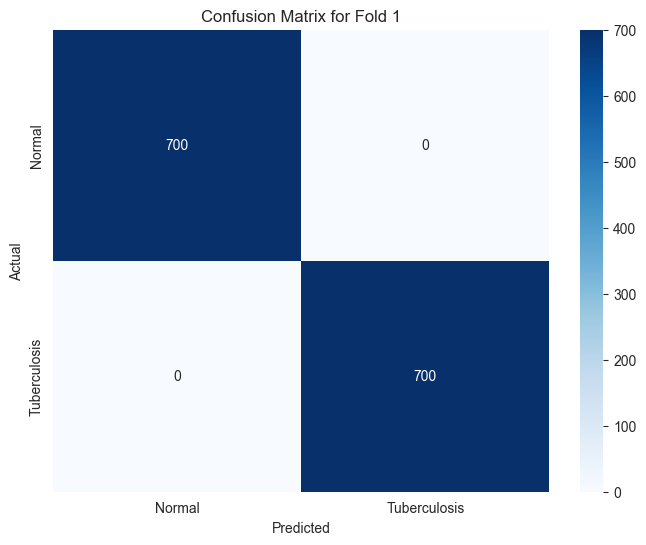

Confusion Matrix for Fold 2


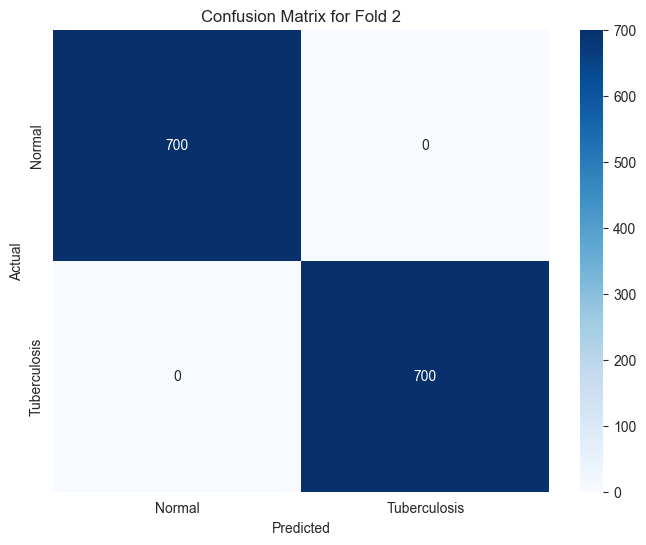

Confusion Matrix for Fold 3


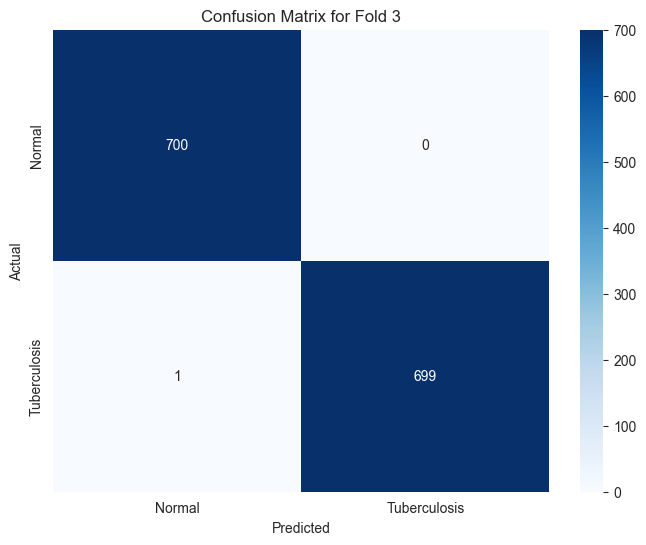

Confusion Matrix for Fold 4


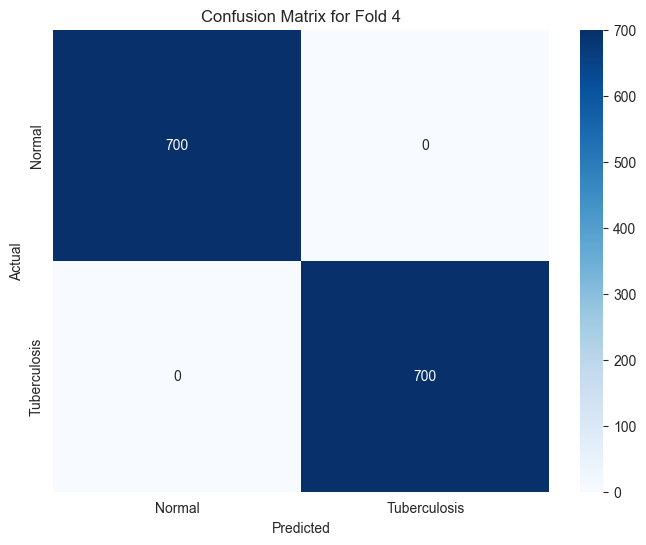

Confusion Matrix for Fold 5


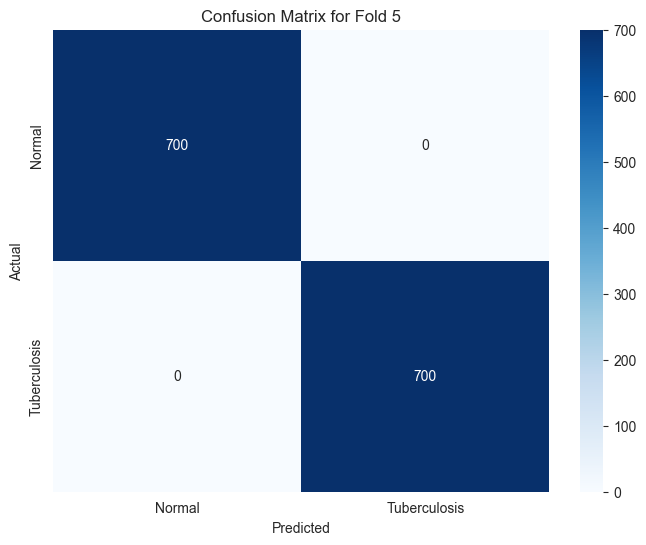

In [9]:
# Plotting confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i+1}")
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


In [10]:
import tensorflow as tf
import pickle

# Save the model in HDF5 format
model.save(r"D:\CapstoneB\MKN maam\Model\DenseNet121kfoldpre.h5")

In [11]:
model.save("DenseNet121kfoldpre.h5")